In [1]:
from utils.analysis.tools import simDir, periodicity_plot
from pathlib import Path
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from utils import plot
from utils.plot import _FIGURE_DIR, get_size_inches, _CM
import time

  from .autonotebook import tqdm as notebook_tqdm



In [2]:
class periodicityPhaseDiagram:
    def __init__(self,
                 directory: str,
                 sweep_file: str = "sweep_parameters.txt"):
        self.sweep_directory = Path(directory)
        self.sweep_file = self.sweep_directory / sweep_file
        self.sweep_parameters = [line.split(",")[0] for line in self.sweep_file.read_text().splitlines()]

    def extract_data(self):
        simdir_paths = [file.parent for file in self.sweep_directory.glob("./*/input_params.txt")]
        self.results = process_map(self.worker,simdir_paths, max_workers=4)
        self.df = pd.DataFrame(self.results)
    
    def worker(self,worker_input,peak_kw={},trough_kw={}):
        simdir_path = worker_input
        sim = simDir(simdir_path)
        param_values = sim.params
        relevant_params = {parameter: str(param_values[parameter]) for parameter in self.sweep_parameters}
        # print(worker_input)
        sim.run()
        sim.rna()
        sim.condensate()
        sim.periodicity(10000,peak_kw,trough_kw)
        period = np.diff(sim.time[sim.peaks],axis=0).mean()
        shortest = np.min([sim.peaks.shape,sim.troughs.shape])
        peaks = sim.peaks[:shortest]
        troughs = sim.troughs[:shortest]
        com_height = np.abs(sim.com[peaks,0]-sim.com[troughs,0]).mean()
        radius_variance_height = np.abs(sim.radius_variance[peaks]-sim.radius_variance[troughs]).mean()
        eccentricity_height = np.abs(sim.eccentricity[peaks]-sim.eccentricity[troughs]).mean()
        rna_height = np.abs(sim.rna_amount[peaks]-sim.rna_amount[troughs]).mean()
        if troughs.size == 0 or peaks.size == 0:
            return relevant_params | {"period": period,
                                  "com_height": com_height,
                                  "radius_variance_height": radius_variance_height,
                                  "eccentricity_height": eccentricity_height,
                                  "rna_height": rna_height,
                                  "xy_trough_end": np.nan,
                                  "xy_peak_end": np.nan,
                                  "c_trough_end": np.nan,
                                  "c_peak_end": np.nan}
        else:
            xy_trough_end = sim.xy[sim.mask[troughs[-1],:]]
            c_trough_end = sim.concentration_profile[0][troughs[-1],:][sim.mask[troughs[-1],:]]
            xy_peak_end = sim.xy[sim.mask[peaks[-1],:]]
            c_peak_end = sim.concentration_profile[0][peaks[-1],:][sim.mask[peaks[-1],:]]
            return relevant_params | {"period": period,
                                    "com_height": com_height,
                                    "radius_variance_height": radius_variance_height,
                                    "eccentricity_height": eccentricity_height,
                                    "rna_height": rna_height,
                                    "xy_trough_end": xy_trough_end,
                                    "xy_peak_end": xy_peak_end,
                                    "c_trough_end": c_trough_end,
                                    "c_peak_end": c_peak_end}

In [3]:
ppd = periodicityPhaseDiagram("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/05_TimeDelay/20240223_PhaseDiagramHillFaster")

In [4]:
# df = df.drop(df.query("tau == 2000").index)
# df.iloc[109] = dct

In [5]:
dct = ppd.worker("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/05_TimeDelay/20240223_PhaseDiagramHillFaster/M1_1.0_b_-0.25_g_-0.1_c_0.03_k_0.05_kp_0.2_c1_3.53_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_1000.0_kd_1.0",
           peak_kw={"height":50})

In [6]:
dct["tau"] = np.float64(dct["tau"])
dct["chiPR_tilde"] = np.float64(dct["chiPR_tilde"])
dct["rna_height"] = np.float64(dct["rna_height"])

In [7]:
# df.to_pickle("20240223_PhaseDiagramHillFasterMoreFixed.pkl")

In [8]:
df = pd.read_pickle("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/05_Analysis/20240223_PhaseDiagramHillFasterMoreFixed.pkl")
df["tau"] = df["tau"].astype(np.float64)
df["chiPR_tilde"] = df["chiPR_tilde"].astype(np.float64)
df["rna_height"] = df["rna_height"].astype(np.float64)

In [9]:
sim = simDir("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/05_TimeDelay/20240223_PhaseDiagramHillFaster/M1_1.0_b_-0.25_g_-0.1_c_0.035_k_0.05_kp_0.2_c1_3.53_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_1000.0_kd_1.0")

In [10]:
sim.run(); sim.condensate(); sim.rna()

In [11]:
sim.periodicity(tinit=10000)

  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=90)



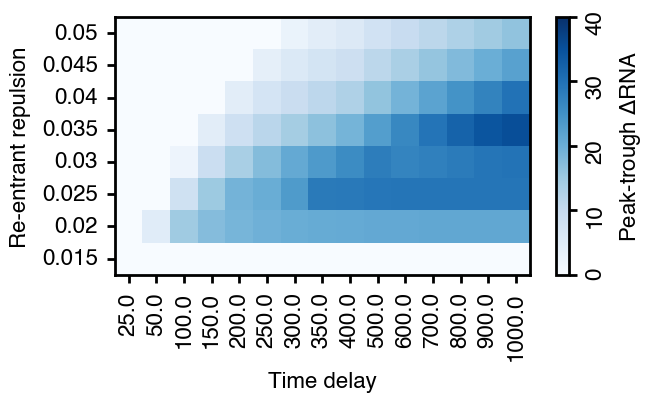

In [12]:
variable = "rna_height"
rna_pivot = df.pivot_table(index="chiPR_tilde",columns="tau",values=variable)
xlabel = "Time delay"
ylabel = "Re-entrant repulsion"
fig, ax = plt.subplots()
fig.set_size_inches(8.5*_CM,8.5*_CM*1/2)
rna_pivot = rna_pivot.loc[::-1]
sns.heatmap(rna_pivot,cmap="Blues",ax=ax,cbar_kws={"label":r"Peak-trough $\Delta$RNA"},
            vmin=0,vmax=40)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.legend()
for spine in ax.spines:
    ax.spines[spine].set_visible(True)
cbar = ax.collections[0].colorbar
cbar.outline.set_color('black')
cbar.outline.set_linewidth(1)
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=90)
plt.savefig(_FIGURE_DIR/"SIFig_Oscillation_DeltaRNA_PhaseDiagram")

  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=90)



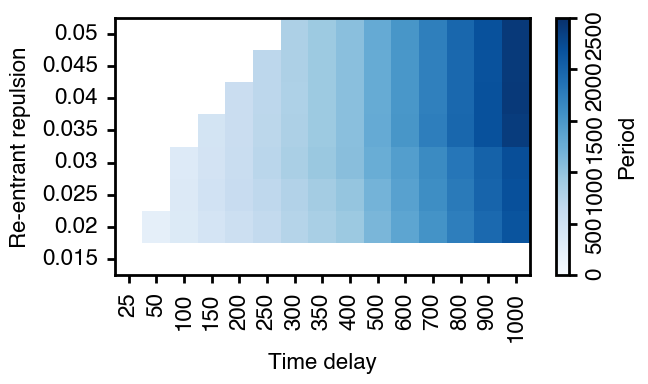

In [13]:
variable = "period"
pivot = df.pivot_table(index="chiPR_tilde",columns="tau",values=variable,dropna=False)
pivot.columns = pivot.columns.astype(int)
pivot[rna_pivot<2] = np.nan
pivot = pivot.loc[::-1]
xlabel = "Time delay"
ylabel = "Re-entrant repulsion"
fig, ax = plt.subplots()
fig.set_size_inches(8.5*_CM,8.5*_CM*1/2)
g = sns.heatmap(pivot,cmap="Blues",ax=ax,cbar_kws={"label":"Period"},
                vmin=0,vmax=2500)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.legend()
for spine in ax.spines:
    ax.spines[spine].set_visible(True)
cbar = ax.collections[0].colorbar
cbar.outline.set_color('black')
cbar.outline.set_linewidth(1)
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=90)
plt.savefig(_FIGURE_DIR/"SIFig_Oscillation_Period_PhaseDiagram")

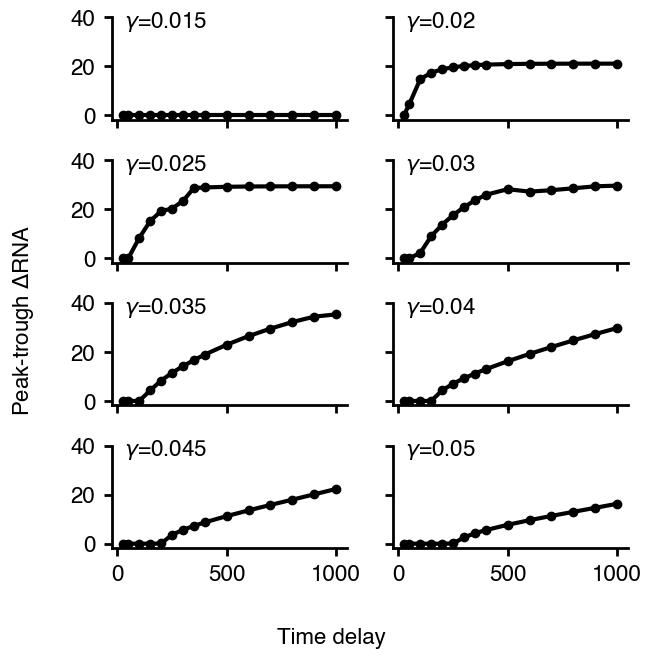

In [14]:
variable = "rna_height"
pivot = df.pivot_table(index="chiPR_tilde",columns="tau",values=variable,dropna=False)
fig, axes = plt.subplots(int(len(pivot.index)/2),2,sharey=True,sharex=True)
fig.set_size_inches(8.5*_CM,8.5*0.25*4*_CM)
axes = axes.flatten()
for i, row in enumerate(pivot.iterrows()):
    if i < len(pivot.index)-2:
        axes[i].tick_params(axis="x",labelbottom=False)
    axes[i].plot(row[1].index,row[1].values,color="black",marker=".",markersize=5)
    axes[i].annotate(f"$\gamma$={row[0]}",(0.05,0.9),xycoords="axes fraction")
    axes[i].set_yticks([0, 20, 40])
fig.supylabel("Peak-trough $\Delta$RNA",fontsize=8)
fig.supxlabel("Time delay",fontsize=8)
fig.tight_layout()
plt.savefig(_FIGURE_DIR/"SIFig_Oscillation_DeltaRNA_Isolated")

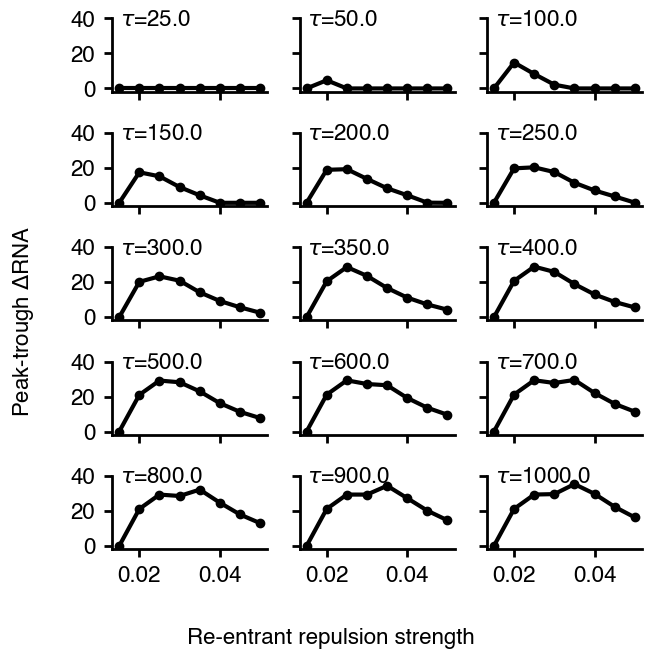

In [15]:
variable = "rna_height"
pivot = df.pivot_table(index="chiPR_tilde",columns="tau",values=variable,dropna=False)
pivot = pivot.transpose()
fig, axes = plt.subplots(int(np.ceil(len(pivot.index)/3)),3,sharex=True,sharey=True)
fig.set_size_inches(8.5*_CM,8.5*0.2*5*_CM)
axes = axes.flatten()
for i, row in enumerate(pivot.iterrows()):
    if i < len(pivot.index)-3:
        axes[i].tick_params(axis="x",labelbottom=False)
    axes[i].plot(row[1].index,row[1].values,color="black",marker=".",markersize=5)
    axes[i].annotate(r"$\tau$"f"={row[0]}",(0.05,0.9),xycoords="axes fraction")
    # axes[i].set_xticks([0, 200, 400])
    axes[i].set_yticks([0, 20, 40])
fig.supylabel("Peak-trough $\Delta$RNA",fontsize=8)
fig.supxlabel("Re-entrant repulsion strength",fontsize=8)
fig.tight_layout()
plt.savefig(_FIGURE_DIR/"SIFig_Oscillation_DeltaRNA_Isolated2")

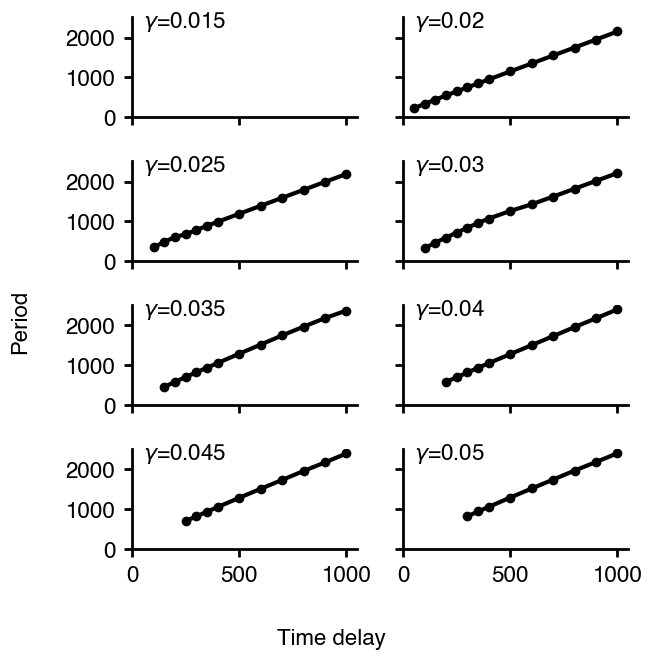

In [16]:
variable = "period"
pivot = df.pivot_table(index="chiPR_tilde",columns="tau",values=variable,dropna=False)
pivot[rna_pivot<2] = np.nan
fig, axes = plt.subplots(int(len(pivot.index)/2),2,sharey=True,sharex=True)
fig.set_size_inches(8.5*_CM,8.5*0.25*4*_CM)
axes = axes.flatten()
for i, row in enumerate(pivot.iterrows()):
    if i < len(pivot.index)-2:
        axes[i].tick_params(axis="x",labelbottom=False)
    axes[i].plot(row[1].index,row[1].values,color="black",marker=".",markersize=5)
    axes[i].annotate(f"$\gamma$={row[0]}",(0.05,0.9),xycoords="axes fraction")
    axes[i].set_xticks([0, 500, 1000])
    axes[i].set_yticks([0, 1000, 2000])
fig.supylabel("Period",fontsize=8)
fig.supxlabel("Time delay",fontsize=8)
# fig.texts[0].set_position((-0.05, 0.5))
fig.tight_layout()
plt.savefig(_FIGURE_DIR/"SIFig_Oscillation_Period_Isolated")

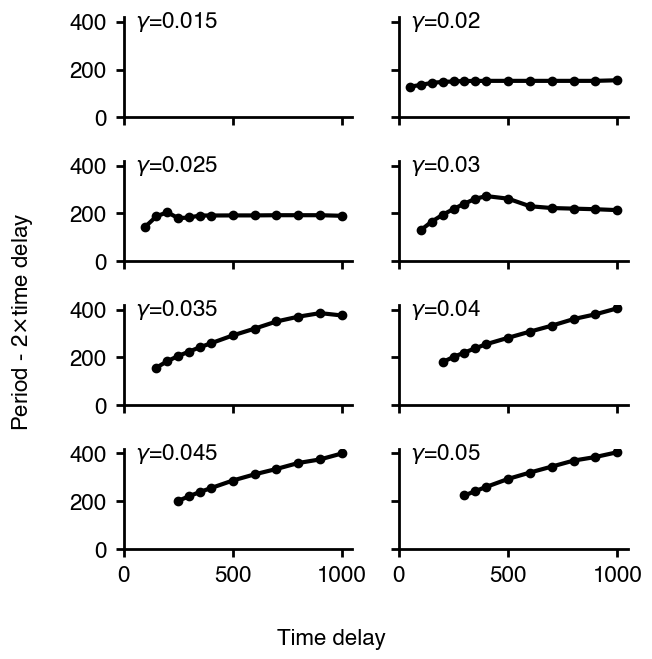

In [17]:
variable = "period"
pivot = df.pivot_table(index="chiPR_tilde",columns="tau",values=variable,dropna=False)
pivot[rna_pivot<2] = np.nan
fig, axes = plt.subplots(int(len(pivot.index)/2),2,sharey=True,sharex=True)
fig.set_size_inches(8.5*_CM,8.5*0.25*4*_CM)
axes = axes.flatten()
for i, row in enumerate(pivot.iterrows()):
    if i < len(pivot.index)-2:
        axes[i].tick_params(axis="x",labelbottom=False)
    axes[i].plot(row[1].index,row[1].values-2*row[1].index,color="black",marker=".",markersize=5)
    axes[i].annotate(f"$\gamma$={row[0]}",(0.05,0.9),xycoords="axes fraction")
    axes[i].set_xticks([0, 500, 1000])
    axes[i].set_yticks([0, 200, 400])
fig.supylabel(r"Period - 2$\times$time delay",fontsize=8)
fig.supxlabel("Time delay",fontsize=8)
fig.tight_layout()
plt.savefig(_FIGURE_DIR/"SIFig_Oscillation_PeriodMin2Tau_Isolated")

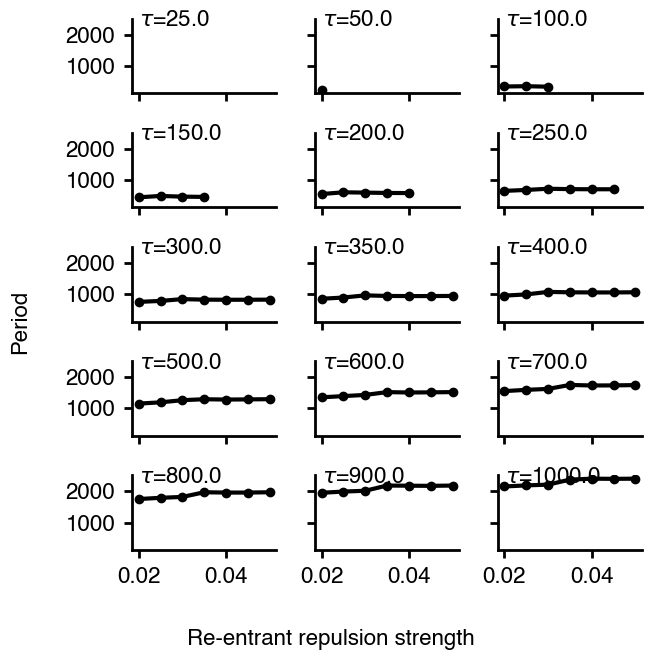

In [18]:
variable = "period"
pivot = df.pivot_table(index="chiPR_tilde",columns="tau",values=variable,dropna=False)
pivot = pivot.transpose()
pivot[rna_pivot[::-1].T<2] = np.nan
fig, axes = plt.subplots(int(np.ceil(len(pivot.index)/3)),3,sharex=True,sharey=True)
fig.set_size_inches(8.5*_CM,8.5*0.2*5*_CM)
axes = axes.flatten()
for i, row in enumerate(pivot.iterrows()):
    if i < len(pivot.index)-3:
        axes[i].tick_params(axis="x",labelbottom=False)
    axes[i].plot(row[1].index,row[1].values,color="black",marker=".",markersize=5)
    axes[i].annotate(r"$\tau$"f"={row[0]}",(0.05,0.9),xycoords="axes fraction")
fig.supylabel("Period",fontsize=8)
fig.supxlabel("Re-entrant repulsion strength",fontsize=8)
fig.tight_layout()
plt.savefig(_FIGURE_DIR/"SIFig_Oscillation_Period_Isolated2")